# 导入

## 导入库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("Set2")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## 定义函数

In [2]:
def plot_category(df, feature, group=None, sort=True):
    """
    为了方便对所有特征进行比较, 建议对连续型特征进行离散化后, 也用这个绘图函数.
    对1个或者2个类别特征进行绘图
    返回两张子图:
    第一张是各个level的样本个数
    第二张是各个level下的均值, 以及95%置信区间
    """
    if not group:
        demand_mean = df.groupby(feature)["demand"].mean().sort_values()
        print("demand均值极差: ", demand_mean.max() - demand_mean.min())
        registered_mean = df.groupby(feature)["registered"].mean().sort_values()
        print("registered均值极差: ", registered_mean.max() - registered_mean.min())
        casual_mean = df.groupby(feature)["casual"].mean().sort_values()
        print("casual均值极差: ", casual_mean.max() - casual_mean.min())        
        if sort:
            order = demand_mean.index
            print(order)
        else:
            order = None
                
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
        sns.countplot(x=feature, hue=group, data=df, ax=ax0, order=order)
        sns.boxplot(x=feature, y="demand", hue=group, data=df, ax=ax1, order=order)
        sns.boxplot(x=feature, y="registered", hue=group, data=df, ax=ax2, order=order)        
        sns.boxplot(x=feature, y="casual", hue=group, data=df, ax=ax3, order=order)
        plt.suptitle(feature)
        
    else:
        
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
        sns.countplot(x=feature, hue=group, data=df, ax=ax0)
        sns.boxplot(x=feature, y="demand", hue=group, data=df, ax=ax1)
        sns.boxplot(x=feature, y="registered", hue=group, data=df, ax=ax2)        
        sns.boxplot(x=feature, y="casual", hue=group, data=df, ax=ax3)
        
        plt.suptitle(feature + " | " + group)
        

## 导入数据

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df = pd.concat([df_train, df_test], ignore_index=True)
df["demand"] = df["count"].copy() # "count"是常见的函数名, 为了防止误会, 改名为"demand"
del df["count"]

n_train = df_train.shape[0]
n_test = df_test.shape[0]
n_all = df.shape[0]

## 观察数据

In [4]:
df.describe(include="all")

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,demand
count,17379,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000
unique,17379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2012-06-26 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132
std,NaN,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454
min,NaN,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000
50%,NaN,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000
75%,NaN,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000


### 数据是共享单车的租赁数据(小时数据).
* 训练集为每个月的前19天.
* 测试集为每个月的第20天到月末.
* 不得不说，数据划分得非常巧妙。
* 时间尺度上，年，月，日，小时，这四个级别，日级别对共享单车需求量的影响最小。
* 年级别的话，随着共享经济的普及，需求量可能是总体向上的，因此，增长多少是比较难预测的。
* 月级别的话，一年四季的变化可能对需求量的影响较大。
* 小时级别的话，考虑早高峰晚高峰，人体生物钟，对需求量影响也很大。
* 暂时想不出日级别对需求量有什么影响，月初，月中，月末，应该不影响需求量。可以画图验证一下。

### 因变量有3列:
1. "casual": 非会员用户的使用量
2. "registered": 会员用户的使用量
3. "demand": 两种用户使用量之和
* 评价指标是基于"demand"的, 但是, 如果分别预测"casual"和"registered", 然后相加, 有可能达到更高的精度
* 当然, 直接预测"demand"也是一种方案, 哪种精度更高需要去尝试验证.

### 自变量分成2大类: 日期时间, 天气状况




* 日期时间:datetime, season, holiday, workingday
1. datetime: 日期时间, 因为是小时数据, 因此, 精度只到了小时这一档.
2. season: 季节: 1到4分别表示春夏秋冬.
3. holiday: 是否是节假日, 取值为0 or 1
4. workingday: 是否是工作日, 取值为0 or 1



* 天气状况: weather, temp, atemp, humidity, windspeed


1. weather: 天气类别:
*    1: Clear, Few clouds, Partly cloudy, Partly cloudy
*    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
*    3: (Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds)
*    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
*    很显然, 数字越大, 表示天气越恶劣



2. temp - 温度, 单位: 摄氏度, 取值为0.82到41
3. atemp - 体感温度, 单位: 摄氏度, 取值为0到50
4. humidity - 相对湿度, 取值为0到100.
5. windspeed - 风速, 取值为0到56.9969

### 除了因变量以外, 没有缺失值, 好消息!

## 因变量变形

* 评价指标:



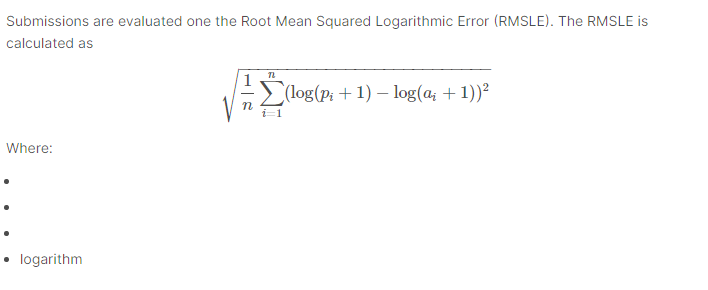

* 这个评价指标的背后逻辑:
* 平衡"淡季"和"旺季"的预测, 否则, 如果直接使用RMSE指标的话, "旺季"的预测结果主导了成绩.
* 有必要先对因变量进行变形, 方便后面的分析计算.

### 变形前的分布:

<AxesSubplot:ylabel='Count'>

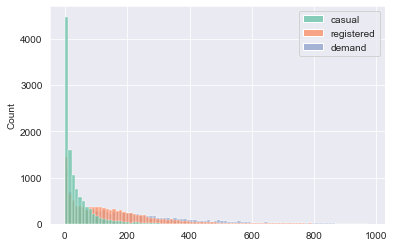

In [5]:
sns.histplot(data=df[["casual", "registered", "demand"]])

* 存在"长尾", 直接使用RMSE, 会被"长尾"数据主导.

In [6]:
df["casual"] = np.log1p(df["casual"])
df["registered"] = np.log1p(df["registered"])
df["demand"] = np.log1p(df["demand"])

### 变形后的分布:

<AxesSubplot:ylabel='Count'>

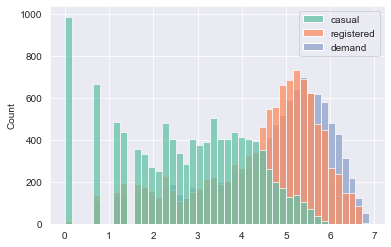

In [7]:
sns.histplot(data=df[["casual", "registered", "demand"]])

* 变形以后, 分布更加接近正态分布.
* "demand"的分布更接近于"registered"的分布, 原因是"registered"贡献了大部分的使用量

In [8]:
df[["casual", "registered", "demand"]].mean()

casual        2.712439
registered    4.395774
demand        4.591364
dtype: float64

* "casual"与"registered"差距是明显的, 如果变形前的数据, 差距更明显.

# EDA以及特征工程

## 提取日期时间特征

In [9]:
df.datetime = pd.to_datetime(df.datetime)
df["year"] = df.datetime.dt.year - 2010 # 目的是为缩短长度
df["month"] = df.datetime.dt.month
df["day"] = df.datetime.dt.day
df["hour"] = df.datetime.dt.hour
df["dayofweek"] = df.datetime.dt.dayofweek

## 单个特征EDA

### year

demand均值极差:  0.5059772466867454
registered均值极差:  0.5296013799975805
casual均值极差:  0.34971130520882454


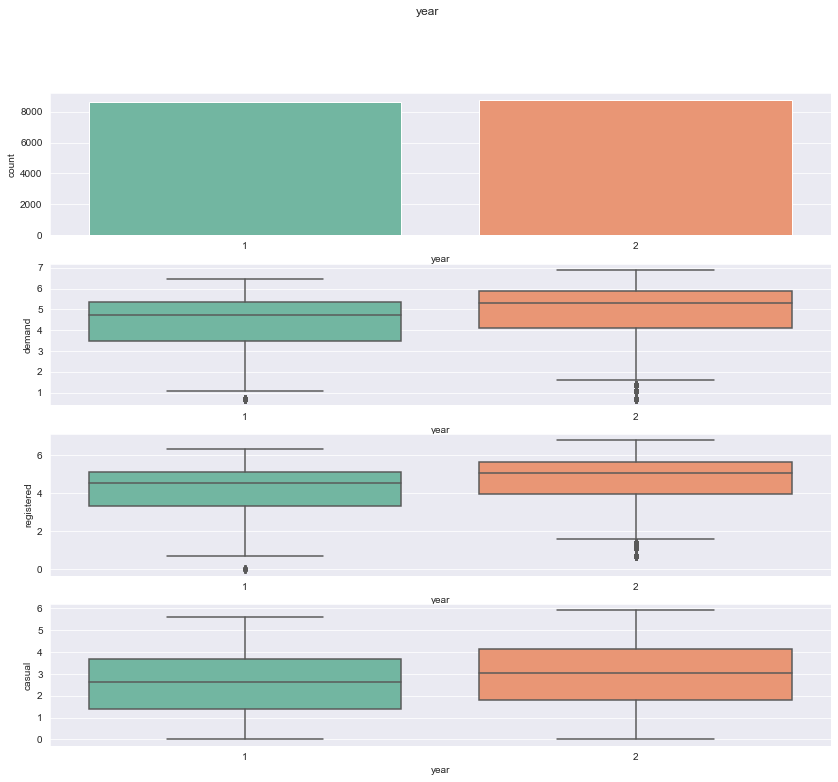

In [10]:
plot_category(df, "year", sort=False)

* 说明需求量总体上上升的.
* 存在着长期趋势.

### season

demand均值极差:  0.8353430290892696
registered均值极差:  0.7049519352916898
casual均值极差:  1.4065340992109905


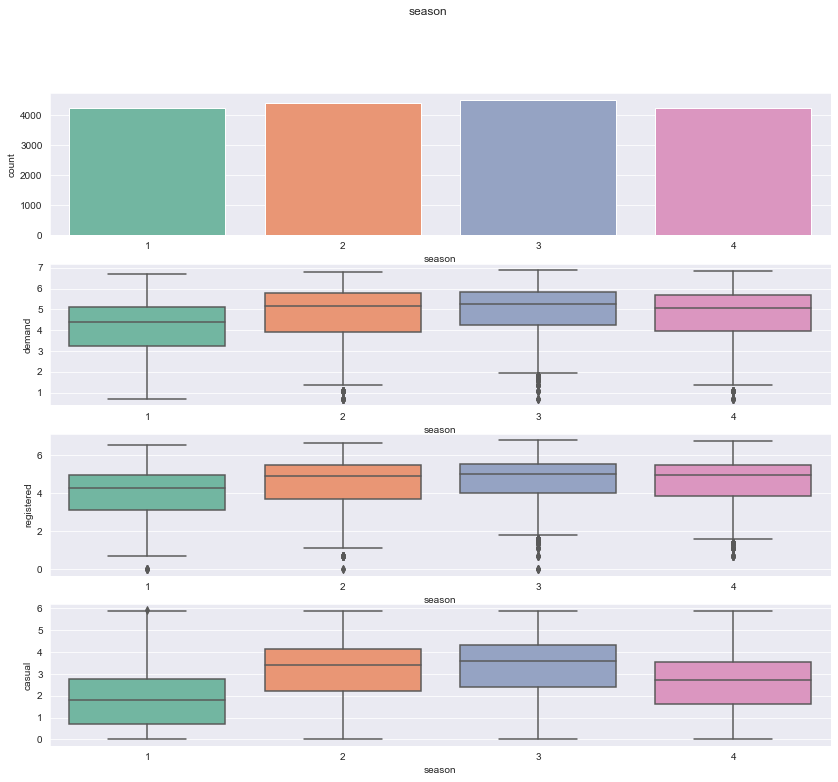

In [11]:
plot_category(df, "season", sort=False)

1. 需求量从大到小依次为: 秋, 夏, 冬, 春
2. causal相比registered波动更大, 因为registered是上班族居多, 需求更稳定.

### month

demand均值极差:  1.0759785234776595
registered均值极差:  0.9142133274506512
casual均值极差:  1.9223663911661613


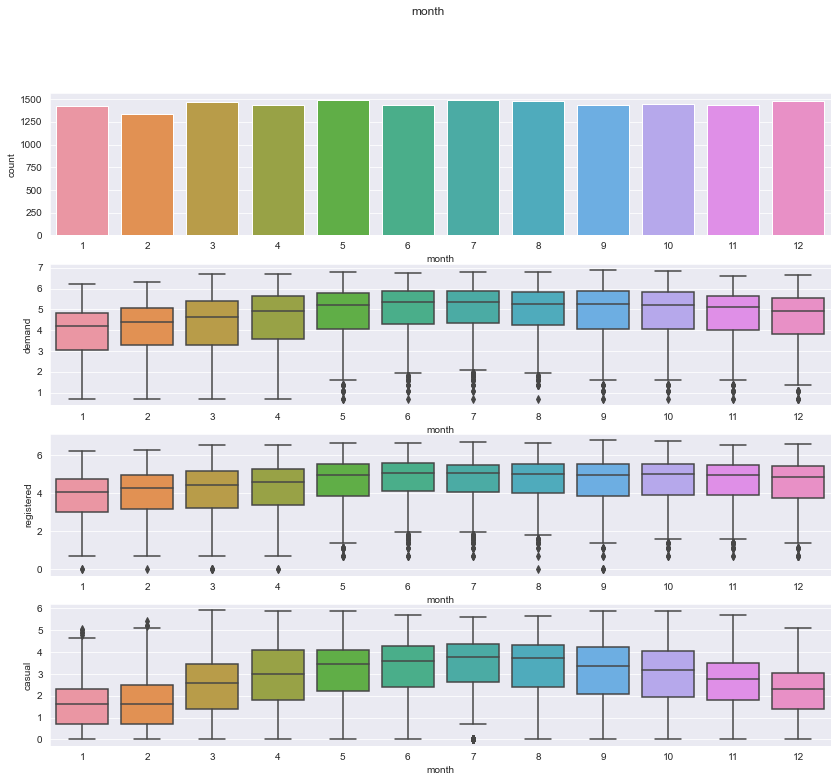

In [12]:
plot_category(df, "month", sort=False)

1. 6, 7, 8月份到达最高峰, 1月份最低谷
2. causal相比registered波动更大, 因为registered是上班族居多, 需求更稳定.

### day(被删除)

demand均值极差:  0.152434099552746
registered均值极差:  0.13129730928626415
casual均值极差:  0.22902046900884176


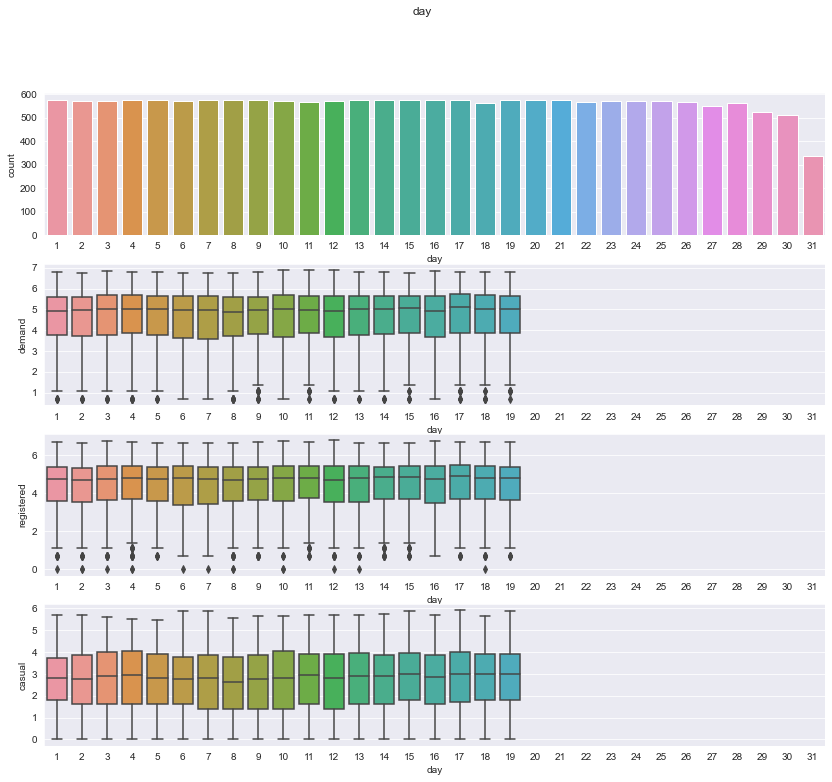

In [13]:
plot_category(df, "day", sort=False)

* 验证了之前的猜想, day对需求量的影响最小, 这就是为什么数据集划分基于day

In [14]:
del df["day"]

### hour

demand均值极差:  4.1633811321247745
registered均值极差:  4.138053794086117
casual均值极差:  3.3507512253859026


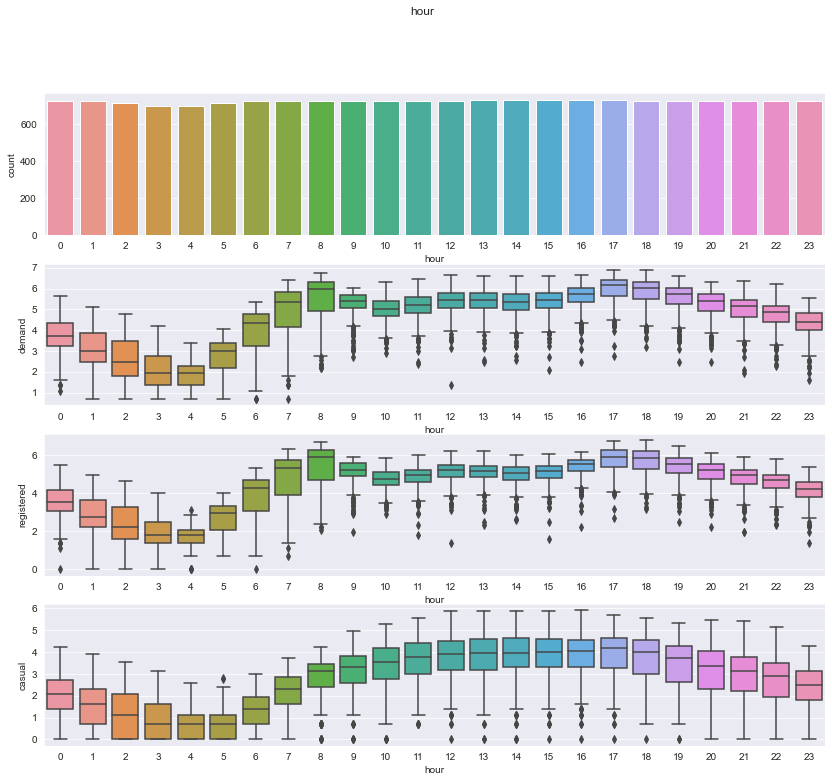

In [15]:
plot_category(df, "hour", sort=False)

* 发现casual只有一个波峰(12点到17点), 而registered有两个波峰, 波峰位置与早晚高峰时间吻合的, 说明registered用户主要是上班族.
* 波谷都在4点左右.

### dayofweek

demand均值极差:  0.18672217287959203
registered均值极差:  0.2352927545844814
casual均值极差:  0.8538269189385836


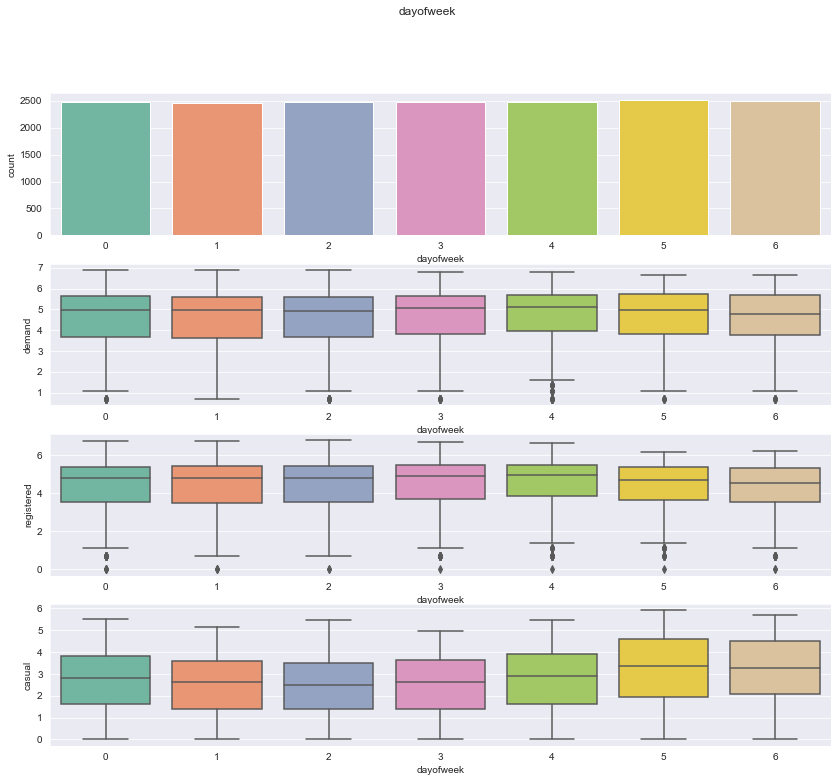

In [16]:
plot_category(df, "dayofweek", sort=False)

* 体现出了casual用户与registered用户存在明显的差别, casual用户喜欢周末出行, registered用户喜欢周末休息

### holiday(被删除)

demand均值极差:  0.010488009616136829
registered均值极差:  0.07522561906000913
casual均值极差:  0.2639099824922351


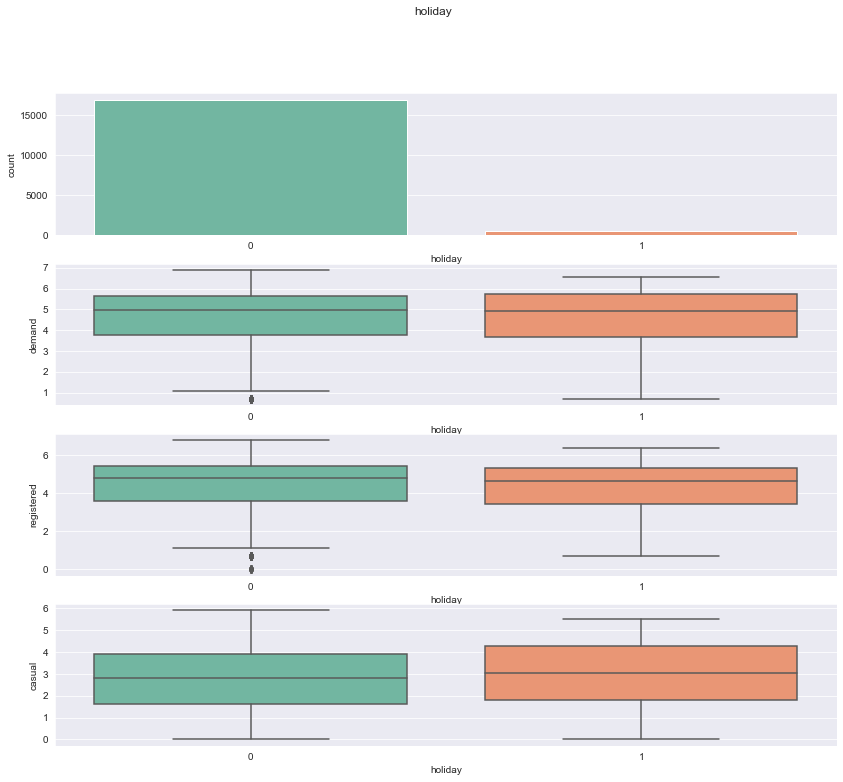

In [17]:
plot_category(df, "holiday", sort=False)

* 体现出了casual用户与registered用户存在明显的差别, casual用户喜欢节假日出行, registered用户喜欢节假日休息

In [18]:
np.sort(df[df["holiday"] == 1].datetime.dt.date.unique())

array([datetime.date(2011, 1, 17), datetime.date(2011, 2, 21),
       datetime.date(2011, 4, 15), datetime.date(2011, 5, 30),
       datetime.date(2011, 7, 4), datetime.date(2011, 9, 5),
       datetime.date(2011, 10, 10), datetime.date(2011, 11, 11),
       datetime.date(2011, 11, 24), datetime.date(2011, 12, 26),
       datetime.date(2012, 1, 2), datetime.date(2012, 1, 16),
       datetime.date(2012, 2, 20), datetime.date(2012, 4, 16),
       datetime.date(2012, 5, 28), datetime.date(2012, 7, 4),
       datetime.date(2012, 9, 3), datetime.date(2012, 10, 8),
       datetime.date(2012, 11, 12), datetime.date(2012, 11, 22),
       datetime.date(2012, 12, 25)], dtype=object)

* 发现节假日的日期比较少, 训练集里面的节假日更少了, 因此, "holiday"可能不适合作为特征, 因为样本太少了.

In [19]:
del df["holiday"]

### workingday

demand均值极差:  0.04666899196772345
registered均值极差:  0.09582798575749418
casual均值极差:  0.6675958310604178


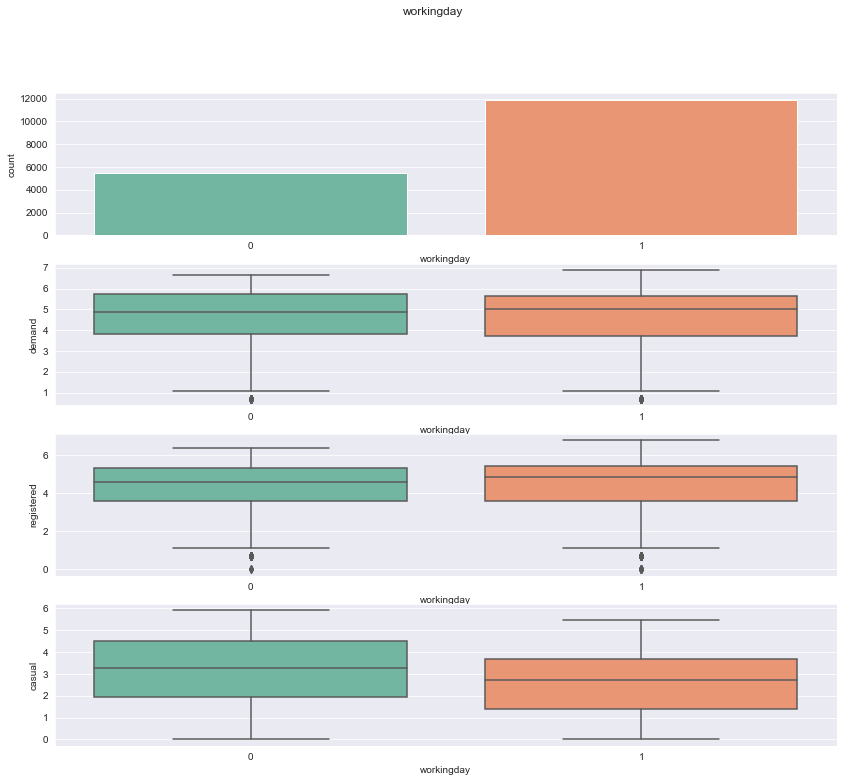

In [20]:
plot_category(df, "workingday", sort=False)

* 体现出了casual用户与registered用户存在明显的差别, casual用户喜欢工作日休息, registered用户喜欢工作日出行

### weather

In [21]:
df.weather.value_counts()

1    11413
2     4544
3     1419
4        3
Name: weather, dtype: int64

* weather == 4的样本只有3个, 不具有参考性, 将3与4合并

In [22]:
df.weather.replace(4, 3, inplace=True)
df.weather.value_counts()

1    11413
2     4544
3     1422
Name: weather, dtype: int64

demand均值极差:  0.6222199030870952
registered均值极差:  0.557357138317188
casual均值极差:  0.8613420571454828


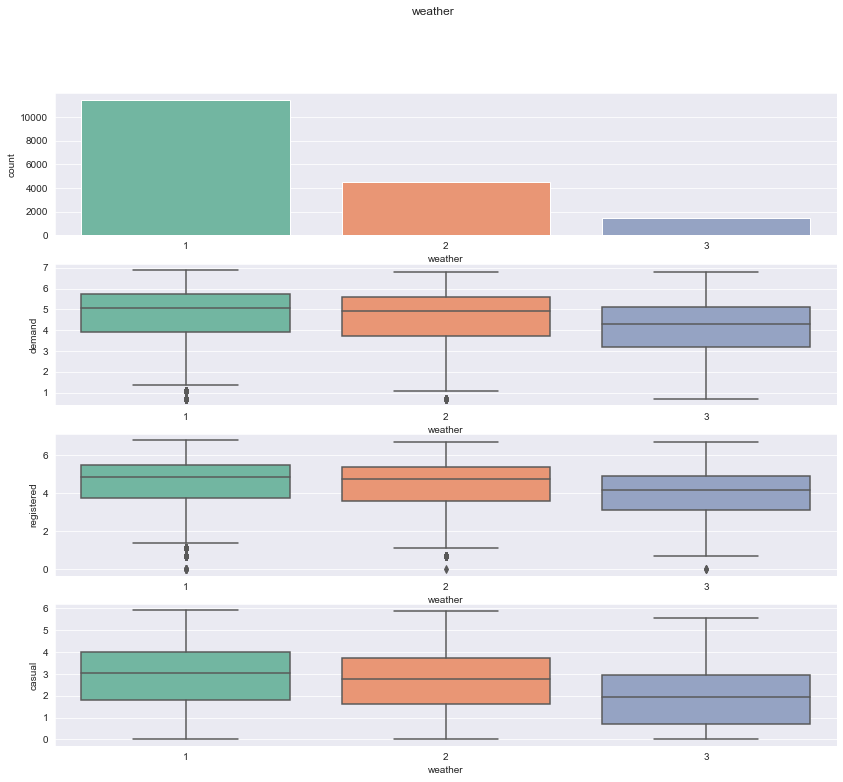

In [23]:
plot_category(df, "weather", sort=False)

* weather越大(越恶劣), 需求量越小, 符合预期

### temp

demand均值极差:  2.152334018443472
registered均值极差:  1.911503563638259
casual均值极差:  3.12798053419904


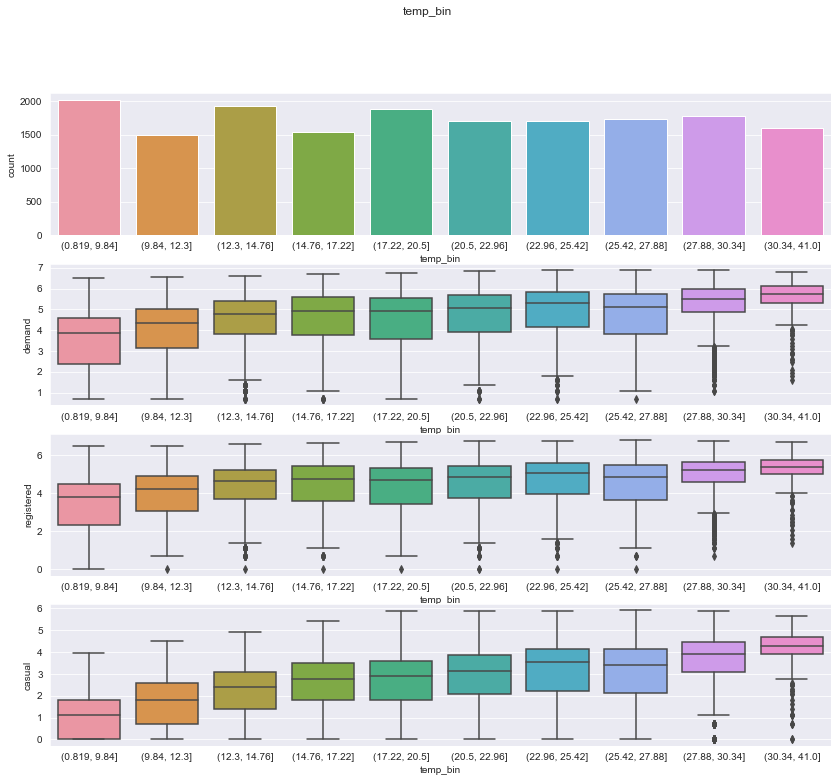

In [24]:
df["temp_bin"] = pd.qcut(df["temp"], 10)
plot_category(df, "temp_bin", sort=False)

* 温度越高, 需求量越大.
* 部分是时间因素(间接影响): 需求量大的时间段是白天, 而白天温度相对晚上是比较高的.
* 当然了, 排除掉时间因素, 温度对需求量的直接影响是有的.

### atemp(被删除)

demand均值极差:  1.9929477976353271
registered均值极差:  1.754655564203056
casual均值极差:  2.972984038092054


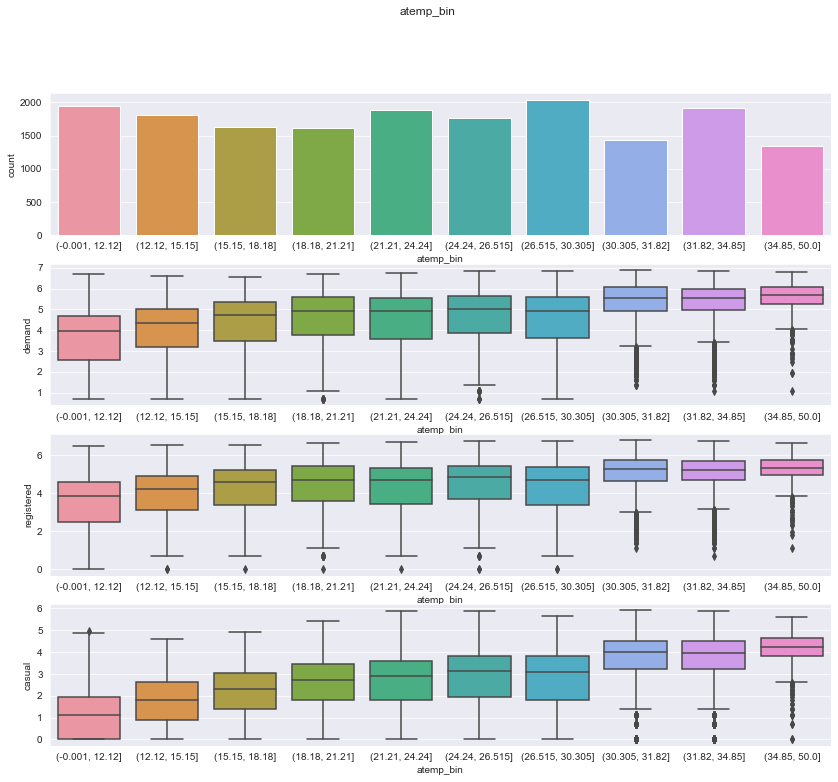

In [25]:
df["atemp_bin"] = pd.qcut(df["atemp"], 10)
plot_category(df, "atemp_bin", sort=False)

* 体感温度越高, 需求量越大.
* 部分是时间因素(间接影响): 需求量大的时间段是白天, 而白天体感温度相对晚上是比较高的.
* 当然了, 排除掉时间因素, 体感温度对需求量的直接影响是有的.

#### atemp与temp的关系

<AxesSubplot:xlabel='temp', ylabel='atemp'>

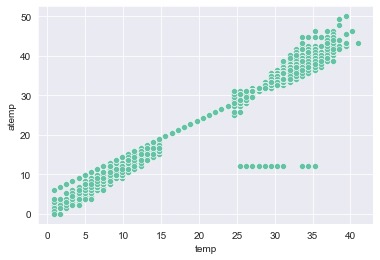

In [26]:
sns.scatterplot(x="temp", y="atemp", data=df)

* 发现了两个看点:
1. temp与atemp基本上是强相关的.
2. atemp似乎有错误数据. temp在25到35范围的部分样本点, atemp为常数(10多点), 这明显是与第1点矛盾的. 从直觉上看, 这些是错误数据.

* 因此, 比较简单的做法是将"atemp"特征删除.

In [27]:
del df["atemp"], df["atemp_bin"]

### humidity

demand均值极差:  1.6998537118708708
registered均值极差:  1.5746102374962412
casual均值极差:  2.0612394081105725


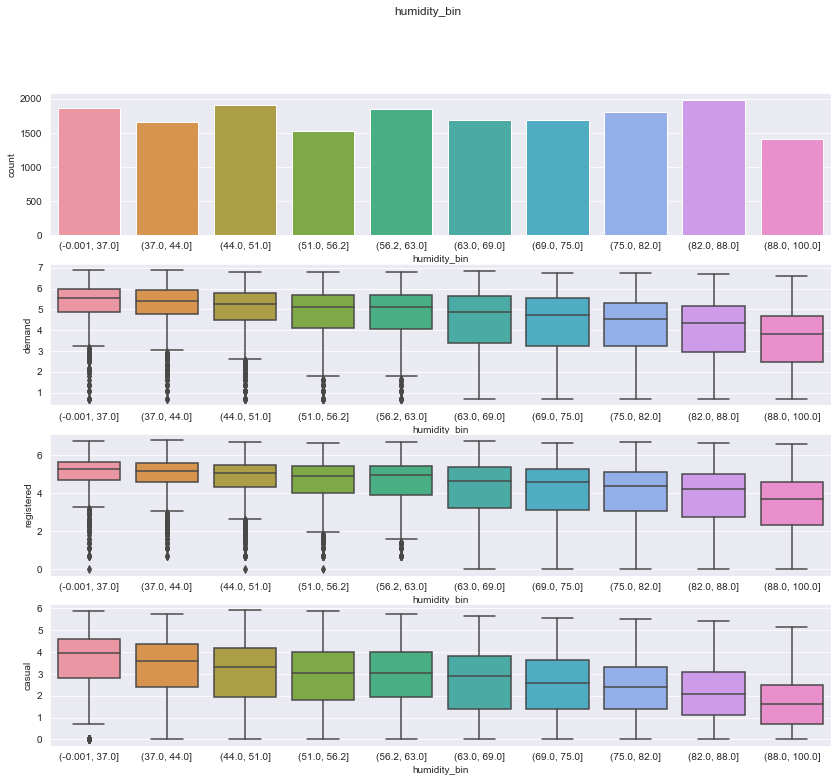

In [28]:
df["humidity_bin"] = pd.qcut(df["humidity"], 10)
plot_category(df, "humidity_bin", sort=False)

* 相对湿度越小, 需求量越大, 说明普遍喜欢干燥的天气.

### windspeed

demand均值极差:  0.5301482289906287
registered均值极差:  0.5217298468368687
casual均值极差:  0.5916331861494304


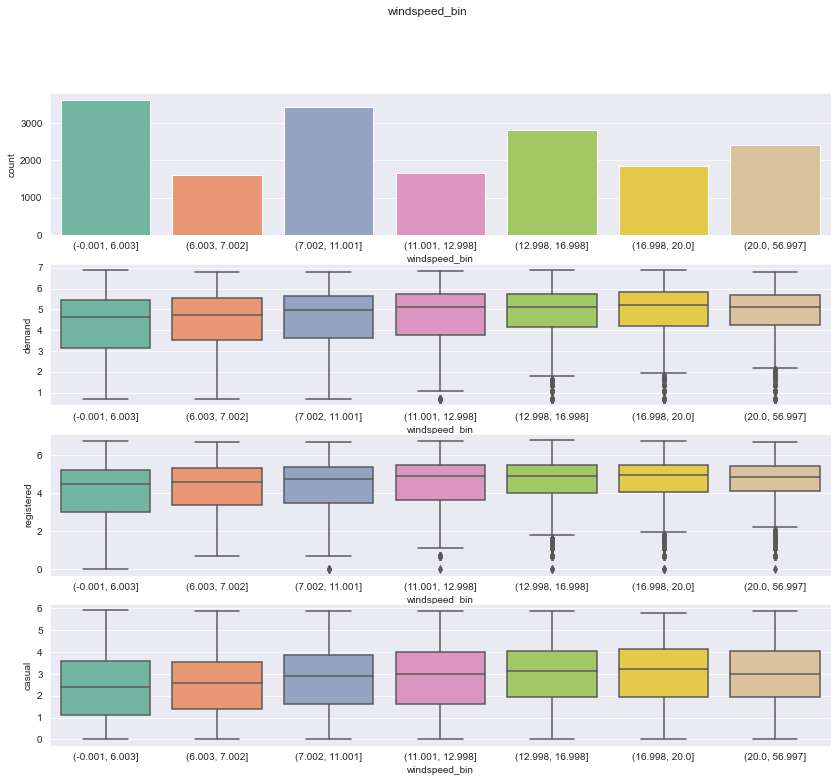

In [29]:
df["windspeed_bin"] = pd.qcut(df["windspeed"], 7)
plot_category(df, "windspeed_bin", sort=False)

* 除了最高档以外, 风速越大, 需求量越大, 这不太符合生活常识.
* 经过分析, 发现很可能是"hour"间接影响:

<AxesSubplot:xlabel='hour', ylabel='windspeed'>

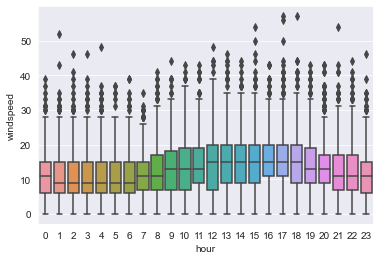

In [30]:
sns.boxplot(x="hour", y="windspeed", data=df)

* 发现有趣的现象, 风速与"hour"有关
* 总体上, 白天风大, 晚上风小, 而恰巧需求量也是白天大, 晚上小
* 从而看起来, 风速与需求量呈正相关.
* 相关性不代表因果性, 这就是一个典型的例子.
* 虽然找到了"hour"这个间接影响, 但是还是不能排除有可能存在直接影响, 遵循"疑罪从无"原则, 还是保留"windspeed"这个特征.

## 二重交叉特征

### hour | workingday

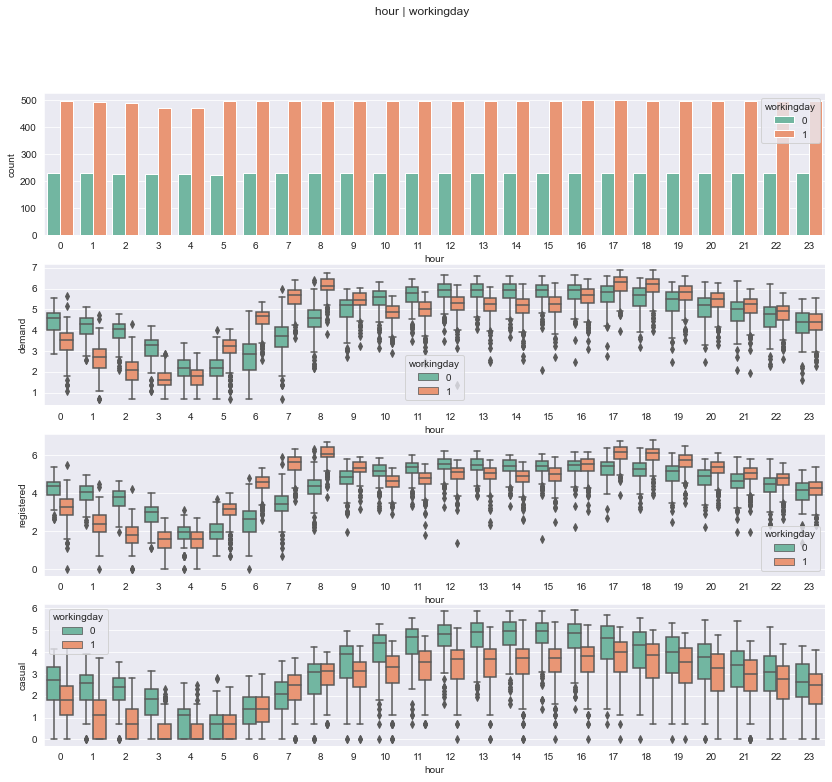

In [31]:
plot_category(df, "hour", "workingday")

* 二重交叉特征很多, 但是只保留了这一组: "hour | workingday"
* 理由是这组二重交叉特征有非常特殊的性质: 出现了非常明显的交叉.
* 对于"demand"或者"registered": 
1. 0到4时, 非工作日需求量 > 工作日需求量
2. 5到9时, 非工作日需求量 < 工作日需求量
3. 10时到15时或16时, 非工作日需求量 > 工作日需求量
4. 16时或17日到23时, 非工作日需求量 < 工作日需求量

* 换种角度来说, 对于"demand"或者"registered": 工作日的小时曲线和非工作日的小时曲线形状差异很大:
* 工作日的小时曲线存在两个高峰, 体现了早高峰和晚高峰.
* 非工作日的小时曲线一个高峰, 在10时到16时, 反映了周末普遍睡懒觉, 另外0时到4时, 需求量大于工作日的需求量, 反映了周末有更多的夜生活.

demand均值极差:  4.5128940389474455
registered均值极差:  4.55924098300148
casual均值极差:  4.305585574549326
Index(['3_1', '4_1', '2_1', '4_0', '5_0', '1_1', '6_0', '5_1', '3_0', '0_1',
       '7_0', '2_0', '1_0', '23_0', '23_1', '0_0', '8_0', '6_1', '22_0',
       '22_1', '10_1', '21_0', '11_1', '9_0', '20_0', '14_1', '21_1', '15_1',
       '13_1', '12_1', '19_0', '20_1', '9_1', '10_0', '18_0', '7_1', '16_1',
       '11_0', '17_0', '19_1', '16_0', '15_0', '14_0', '12_0', '13_0', '18_1',
       '8_1', '17_1'],
      dtype='object', name='hour_workingday')


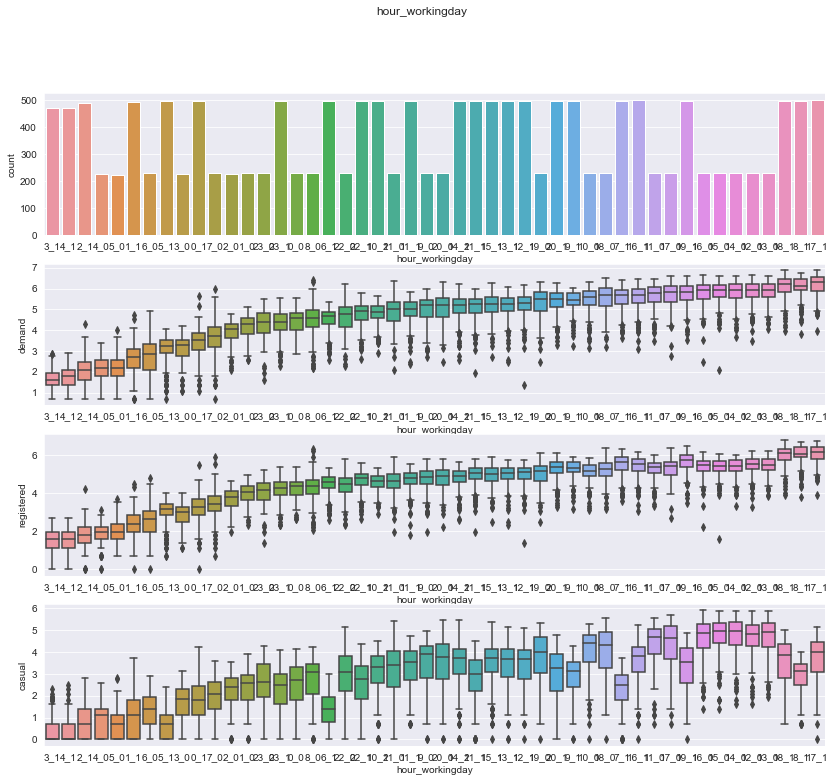

In [32]:
df["hour_workingday"] = df["hour"].astype(str) + "_" + df["workingday"].astype(str)
plot_category(df, "hour_workingday")

# 机器学习

## 准备好机器学习需要的自变量矩阵与因变量

In [33]:
X = df.drop(columns=["casual", "registered", "demand", "datetime", "temp_bin", "humidity_bin", "windspeed_bin", "hour_workingday"]).copy()
Y = df[["demand", "registered", "casual"]]
print("\nX:")
print(X.head())
print("\nY:")
print(Y.head())

# 非工作日大部分在周六或周天, 少部分在其他, 现在将所有少部分都统一归并在了周一, 防止小样本造成的误导.
X.loc[(df.workingday == 0) & (~X.dayofweek.isin([5, 6])), "dayofweek"] = 0

# 为了照顾线性模型, 将一些特征进行独热编码:
# X = pd.get_dummies(X, columns=["season", "weather", "month", "hour", "dayofweek"])
# print("\nX:")
# print(X.head())


X:
   season  workingday  weather  temp  humidity  windspeed  year  month  hour  \
0       1           0        1  9.84        81        0.0     1      1     0   
1       1           0        1  9.02        80        0.0     1      1     1   
2       1           0        1  9.02        80        0.0     1      1     2   
3       1           0        1  9.84        75        0.0     1      1     3   
4       1           0        1  9.84        75        0.0     1      1     4   

   dayofweek  
0          5  
1          5  
2          5  
3          5  
4          5  

Y:
     demand  registered    casual
0  2.833213    2.639057  1.386294
1  3.713572    3.496508  2.197225
2  3.496508    3.332205  1.791759
3  2.639057    2.397895  1.386294
4  0.693147    0.693147  0.000000


## 定义相关函数, class, 常数

In [34]:
from sklearn.model_selection import cross_val_score
from time import time


def best_mean_std(cv_results, multiple=0):
    """
    基于交叉检验分数的均值与标准差, 算出一个综合的分数
    multiple >= 0.
    如果全部基于均值, 那么, multiple=0
    如果基于2.5%分位值, 假设分数满足正态分布, 那么, multiple=1.96
    multiple也可以改成其他数字, 这个数字越大, 表示标准差的权重越大.
    """
    scores = np.array(cv_results["mean_test_score"]) - multiple * np.array(cv_results["std_test_score"])
    best_idx = np.argmax(scores)
    return best_idx


class Model:
    """
    类似于scikit-learn的model, 但是, 增加了超参优化的功能(search)
    """
    def __init__(self, mdl, scoring, cv):
        """
        mdl: 机器学习模型对象, 比如: SVR()
        scoring: 评价指标, 比如: scoring = make_scorer(RMSE, greater_is_better=False)
        cv: 交叉检验的类型, 比如: KFold(n_splits=5, shuffle=True, random_state=random_state)
        """
        self.mdl = mdl
        self.scoring = scoring
        self.cv = cv

    def fit(self, X, y):
        """
        模型训练
        """
        self.mdl.fit(X, y)
        return self

    def predict(self, X):
        """
        模型预测
        """
        y_hat = self.mdl.predict(X)
        return y_hat

    def search(self, X, y, search):
        """
        超参优化
        search: 可以是网格优化器或者随机优化器或者贝叶斯优化器
        """
        t0 = time()
        search.fit(X, y)
        t1 = time()
        print(f"Searching elapses {t1 - t0} seconds.")

        best_idx = best_mean_std(search.cv_results_)
        best_params = dict(search.cv_results_["params"][best_idx])
        print(best_params)
        self.mdl.set_params(**best_params)
        scores_val = cross_val_score(
            self.mdl, X, y, scoring=self.scoring, cv=self.cv
        )
        mu = np.mean(scores_val)
        sigma = np.std(scores_val)
        bounds_left = mu - 1.96 * sigma
        bounds_right = mu + 1.96 * sigma
        print(
            f"val score: {mu:.6f} +- {1.96 * sigma:.6f} = "
            f"({bounds_left:.6f}, {bounds_right:.6f})"
        )

        self.mdl.fit(X, y)
        return best_params

In [35]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split as tts

def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

scoring = make_scorer(RMSE, greater_is_better=False)
random_state = 0
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

scores0_val = {}
scores12_val = {}

X_train = X.loc[Y.notna().all(axis=1)]
X_test = X.loc[Y.isna().any(axis=1)]
Y_train = Y.loc[Y.notna().all(axis=1)]

X_strain, X_val, Y_strain, Y_val = tts(X_train, Y_train,
                                           test_size=0.3,
                                           shuffle=True,
                                           random_state=random_state)

## LGBM


------------------------------
第0个因变量:
Searching elapses 12.711726903915405 seconds.
{'n_estimators': 1100, 'num_leaves': 8}
val score: -0.281498 +- 0.014884 = (-0.296383, -0.266614)
直接预测法, real val score: 0.2848866683138203


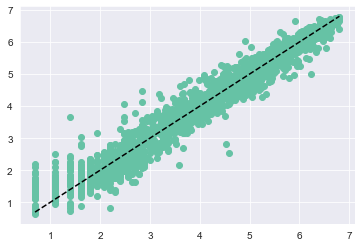


------------------------------
第1个因变量:
Searching elapses 12.779730796813965 seconds.
{'n_estimators': 1100, 'num_leaves': 8}
val score: -0.278619 +- 0.013711 = (-0.292330, -0.264908)


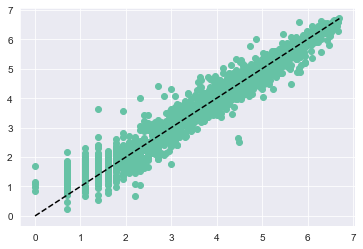


------------------------------
第2个因变量:
Searching elapses 12.572719097137451 seconds.
{'n_estimators': 1100, 'num_leaves': 8}
val score: -0.475549 +- 0.015625 = (-0.491174, -0.459924)
间接预测法, real val score: 0.2831470139384711


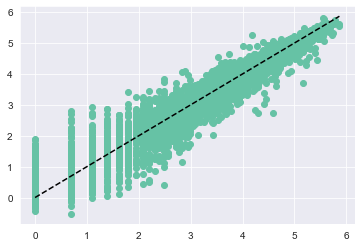

In [36]:
from lightgbm import LGBMRegressor as LGBM
from sklearn.model_selection import GridSearchCV

name = "LGBM"
mdl = LGBM(random_state=random_state)
bike = Model(mdl, scoring, cv)

search_spaces = dict(
    num_leaves=[2, 4, 6, 8],
    n_estimators=[100, 300, 500, 700, 900, 1100],
)

search = GridSearchCV(
    bike.mdl,
    param_grid=search_spaces,
    cv=bike.cv,
    verbose=0,
    refit=False,
    scoring=bike.scoring,
)

for jj in range(3):
    print()
    print("-" * 30)
    print(f"第{jj}个因变量:")
    
    y_train = Y_train.iloc[:, jj]
    y_strain = Y_strain.iloc[:, jj]
    y_val = Y_val.iloc[:, jj]
    
    bike.search(X_strain, y_strain, search)
    
    if jj == 0:
        y_val_hat = bike.predict(X_val)
        score_val = RMSE(Y_val.iloc[:, 0], y_val_hat)
        print(f"直接预测法, real val score: {score_val}")
        scores0_val[name] = score_val

    if jj == 1:
        y_val_hat = bike.predict(X_val)
        
    if jj == 2:
        y_val_hat_last = y_val_hat.copy()
        y_val_hat = bike.predict(X_val)
        
        y_val_hat12 = np.log1p(np.expm1(y_val_hat_last) + np.expm1(y_val_hat))
        score_val = RMSE(Y_val.iloc[:, 0], y_val_hat12)
        print(f"间接预测法, real val score: {score_val}")
        scores12_val[name] = score_val
  
    bike.fit(X_train, y_train)
    y_test_hat = bike.predict(X_test)    
    
    df.loc[X_test.index, f"{name}_pred{jj}"] = y_test_hat
    
    plt.figure()
    plt.scatter(y_val, y_val_hat)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "k--")
    plt.show()

## ET


------------------------------
第0个因变量:
Searching elapses 8.236471176147461 seconds.
{'min_samples_leaf': 1}
val score: -0.305610 +- 0.014069 = (-0.319679, -0.291541)
直接预测法, real val score: 0.3116998247127625


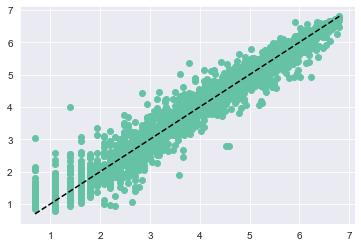


------------------------------
第1个因变量:
Searching elapses 5.456311941146851 seconds.
{'min_samples_leaf': 3}
val score: -0.301877 +- 0.021051 = (-0.322927, -0.280826)


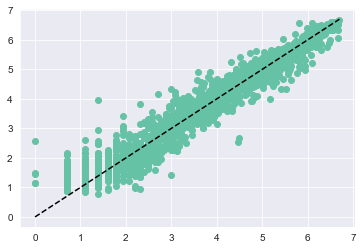


------------------------------
第2个因变量:
Searching elapses 5.503314733505249 seconds.
{'min_samples_leaf': 3}
val score: -0.482646 +- 0.017377 = (-0.500022, -0.465269)
间接预测法, real val score: 0.30421938268028587


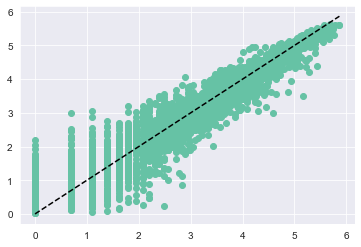

In [37]:
from sklearn.ensemble import ExtraTreesRegressor as ET
from sklearn.model_selection import GridSearchCV

name = "ET"
mdl = ET(n_jobs=-1, random_state=random_state)
bike = Model(mdl, scoring, cv)

search_spaces = dict(
    min_samples_leaf=[1, 3, 5, 10],
)

search = GridSearchCV(
    bike.mdl,
    param_grid=search_spaces,
    cv=bike.cv,
    verbose=0,
    refit=False,
    scoring=bike.scoring,
)

for jj in range(3):
    print()
    print("-" * 30)
    print(f"第{jj}个因变量:")
    
    y_train = Y_train.iloc[:, jj]
    y_strain = Y_strain.iloc[:, jj]
    y_val = Y_val.iloc[:, jj]
    
    bike.search(X_strain, y_strain, search)
    
    if jj == 0:
        y_val_hat = bike.predict(X_val)
        score_val = RMSE(Y_val.iloc[:, 0], y_val_hat)
        print(f"直接预测法, real val score: {score_val}")
        scores0_val[name] = score_val

    if jj == 1:
        y_val_hat = bike.predict(X_val)
        
    if jj == 2:
        y_val_hat_last = y_val_hat.copy()
        y_val_hat = bike.predict(X_val)
        
        y_val_hat12 = np.log1p(np.expm1(y_val_hat_last) + np.expm1(y_val_hat))
        score_val = RMSE(Y_val.iloc[:, 0], y_val_hat12)
        print(f"间接预测法, real val score: {score_val}")
        scores12_val[name] = score_val
  
    bike.fit(X_train, y_train)
    y_test_hat = bike.predict(X_test)    
    
    df.loc[X_test.index, f"{name}_pred{jj}"] = y_test_hat
    
    plt.figure()
    plt.scatter(y_val, y_val_hat)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "k--")
    plt.show()

## RF


------------------------------
第0个因变量:
Searching elapses 6.233356237411499 seconds.
{'min_samples_leaf': 1}
val score: -0.309636 +- 0.017930 = (-0.327566, -0.291707)
直接预测法, real val score: 0.31391348003539


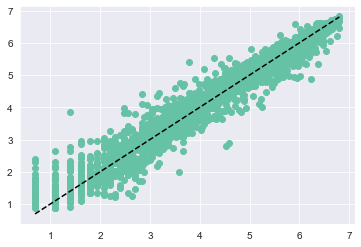


------------------------------
第1个因变量:
Searching elapses 6.433367967605591 seconds.
{'min_samples_leaf': 1}
val score: -0.300725 +- 0.022368 = (-0.323093, -0.278357)


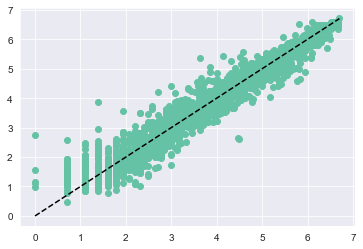


------------------------------
第2个因变量:
Searching elapses 6.229356288909912 seconds.
{'min_samples_leaf': 3}
val score: -0.495662 +- 0.013498 = (-0.509160, -0.482165)
间接预测法, real val score: 0.30494467191598335


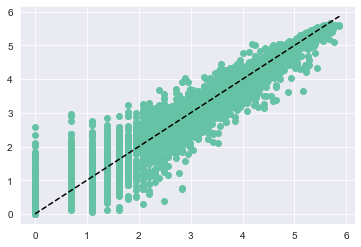

In [38]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import GridSearchCV

name = "RF"
mdl = RF(n_jobs=-1, random_state=random_state)
bike = Model(mdl, scoring, cv)

search_spaces = dict(
    min_samples_leaf=[1, 3, 5, 10],
)

search = GridSearchCV(
    bike.mdl,
    param_grid=search_spaces,
    cv=bike.cv,
    verbose=0,
    refit=False,
    scoring=bike.scoring,
)

for jj in range(3):
    print()
    print("-" * 30)
    print(f"第{jj}个因变量:")
    
    y_train = Y_train.iloc[:, jj]
    y_strain = Y_strain.iloc[:, jj]
    y_val = Y_val.iloc[:, jj]
    
    bike.search(X_strain, y_strain, search)

    if jj == 0:
        y_val_hat = bike.predict(X_val)
        score_val = RMSE(Y_val.iloc[:, 0], y_val_hat)
        print(f"直接预测法, real val score: {score_val}")
        scores0_val[name] = score_val

    if jj == 1:
        y_val_hat = bike.predict(X_val)
        
    if jj == 2:
        y_val_hat_last = y_val_hat.copy()
        y_val_hat = bike.predict(X_val)
        
        y_val_hat12 = np.log1p(np.expm1(y_val_hat_last) + np.expm1(y_val_hat))
        score_val = RMSE(Y_val.iloc[:, 0], y_val_hat12)
        print(f"间接预测法, real val score: {score_val}")
        scores12_val[name] = score_val   
  
    bike.fit(X_train, y_train)
    y_test_hat = bike.predict(X_test)    
    
    df.loc[X_test.index, f"{name}_pred{jj}"] = y_test_hat
    
    plt.figure()
    plt.scatter(y_val, y_val_hat)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "k--")
    plt.show()

## 小结

### 验证集表现汇总

In [39]:
pd.DataFrame({"直接预测法": scores0_val, "间接预测法": scores12_val})

,直接预测法,间接预测法
LGBM,0.284887,0.283147
ET,0.311700,0.304219
RF,0.313913,0.304945


列之间进行比较的话:
* 发现间接预测法优于直接预测法.
* 直接预测法的意思是直接预测因变量"demand"
* 间接预测法的意思是分别预测"registered"和"casual", 然后相加, 得到"demand"的预测值

行之间进行比较的话:
* LGBM显著好于ET, RF
* ET, RF差不多
* 因此, 设置它们的权重分别是1:0:0

### 将三个模型的结果加权平均

In [40]:
pred1 = np.expm1((1 * df["LGBM_pred1"] + 0 * df["ET_pred1"] + 0 * df["RF_pred1"])/1)[n_train:]
pred2 = np.expm1((1 * df["LGBM_pred2"] + 0 * df["ET_pred2"] + 0 * df["RF_pred2"])/1)[n_train:]
pred12 = pred1 + pred2

df_submit = pd.DataFrame({"datetime" : df_test.datetime,
                          "count" : pred12.values
                         })
df_submit.to_csv("bike_voting.csv", index=False)

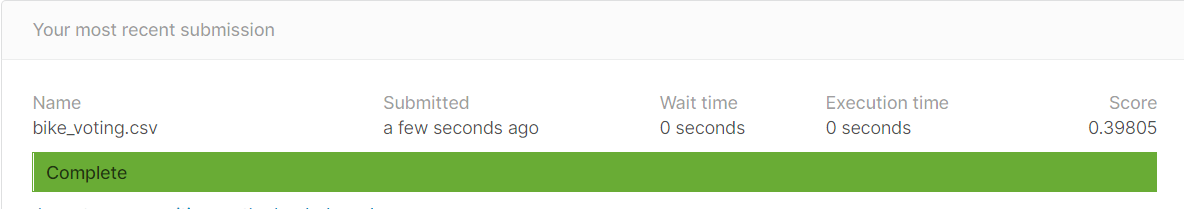

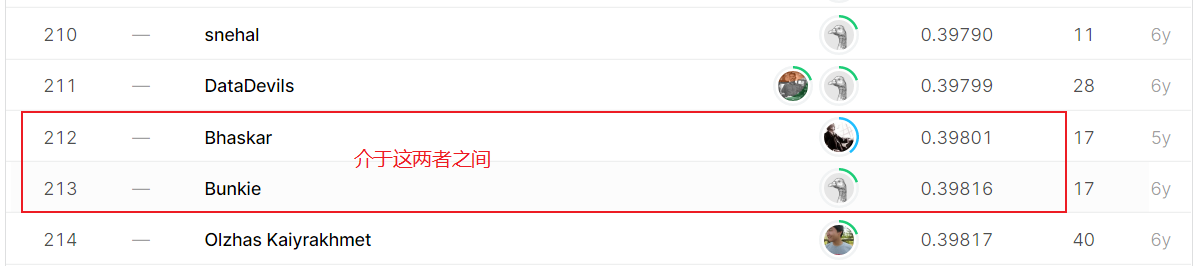

* 排名213/3242 = 6.6%
* 结果还行, 不能过于较真, 因为:
> "The private leaderboard is calculated over the same rows as the public leaderboard in this competition. This competition has completed. This leaderboard reflects the final standings."

* 所以, 排名比我靠前的, 有可能是过拟的结果.

### 结果解释

* 验证集的分数是: 0.283147, 而测试集的分数是0.39805, 结果差异是比较显著的.
* 主要原因:
* "测试集与训练集的差异"远远大于"验证集与训练集的差异".
   测试集是每个月的20日到月底
   训练集是每个月的月初到19日, 时间上是完全是错开来的.
   而验证集是从训练集里面随机抽取的, 时间上是嵌入的关系.
   验证集的样本从训练集里面能够获得邻近点(时间上的)
   而测试集的样本无法从训练集里面能够获得邻近点(时间上的), 除了起始几个样本和末尾几个样本以外.   

## 未来可能的改进点

1. 几乎没有生成新的特征
2. 当成了横截面数据, 没有使用时间序列上的一些手段, 比如移动平均.